In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad, jit
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qujax import tk_to_qujax
import qujax
import matplotlib.pyplot as plt

# Define the classification task<br>
We'll try and learn a _donut_ binary classification function (i.e. a bivariate coordinate is labelled 1 if it is inside the donut and 0 if it is outside)

In [2]:
inner_rad = 0.25; outer_rad = 0.75
def classification_function(x, y):
    r = jnp.sqrt(x**2 + y**2)
    return jnp.where((r > inner_rad)*(r < outer_rad), 1, 0)

In [3]:
linsp = jnp.linspace(-1, 1, 1000)
Z = vmap(lambda x: vmap(lambda y: classification_function(x, y))(linsp))(linsp)

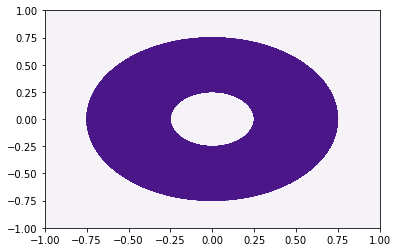

In [4]:
plt.contourf(linsp, linsp, Z, cmap='Purples');

Now let's generate some data for our quantum circuit to learn from

In [5]:
n_data = 1000
x = random.uniform(random.PRNGKey(0), shape=(n_data, 2), minval=-1, maxval=1)
y = classification_function(x[:,0], x[:, 1])

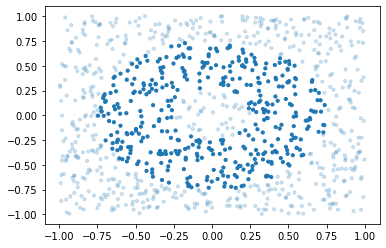

In [6]:
plt.scatter(x[:,0], x[:,1], alpha=jnp.where(y, 1, 0.2), s=10);

# Quantum circuit time<br>
We'll use a variant of data re-uploading [Pérez-Salinas et al](https://doi.org/10.22331/q-2020-02-06-226) to encode the input data, alongside some variational parameters within a quantum circuit classifier

In [7]:
n_qubits = 3
depth = 5

In [8]:
c = Circuit(n_qubits)

In [9]:
for layer in range(depth):
    for qi in range(n_qubits):
        c.Rz(0., qi)
        c.Ry(0., qi)
        c.Rz(0., qi)
    
    if layer < (depth - 1):
        for qi in range(layer, layer + n_qubits - 1, 2):
            c.CZ(qi % n_qubits, (qi + 1) % n_qubits)
        c.add_barrier(range(n_qubits))

In [10]:
render_circuit_jupyter(c)

We can use `pytket-qujax` to generate our angles-to-statetensor function.

In [11]:
angles_to_st = tk_to_qujax(c)

We'll parameterise each angle as<br>
$$ \theta_k = b_k + w_k * x_k $$<br>
where $b_k, w_k$ are variational parameters to be learnt and $x_k = x_0$ if $k$ even, $x_k = x_1$ if $k$ odd for a single bivariate input point $(x_0, x_1)$.

In [12]:
n_angles = 3 * n_qubits * depth
n_params = 2 * n_angles

In [13]:
def param_and_x_to_angles(param, x_single):
    biases = param[:n_angles]
    weights = param[n_angles:]
    
    weights_times_data = jnp.where(jnp.arange(n_angles) % 2 == 0, weights * x_single[0], weights * x_single[1])
    
    angles = biases + weights_times_data
    return angles

In [14]:
param_and_x_to_st = lambda param, x_single: angles_to_st(param_and_x_to_angles(param, x_single))

We'll measure the first qubit only (if its 1 we label _donut_, if its 0 we label _not donut_)

In [15]:
def param_and_x_to_probability(param, x_single):
    st = param_and_x_to_st(param, x_single)
    all_probs = jnp.square(jnp.abs(st))
    first_qubit_probs = jnp.sum(all_probs, axis=range(1, n_qubits))
    return first_qubit_probs[1]

The ideal loss function is the log-likelihood<br>
$$ \log p(y \mid q_{(b, w)}(x)) = {\mathbb{I}[y = 0]}\log(1 - q_{(b, w)}(x)) + {\mathbb{I}[y = 1]} \log(q_{(b, w)}(x))$$<br>
where $q_{(b, w)}(x)$ is the probability the quantum circuit classifies input $x$ as donut given variational parameter vectors $(b, w)$. However this cannot be approximated unbiasedly with shots (in qujax simulations we can use the statetensor to calculate this exactly, but it is still good to keep in mind loss functions that can also be used with shots from a quantum device).

Instead we can minimise the expected Hamming distance between shots and data<br>
$$ C(b, w, x, y) = \mathbb{E}_{y' \sim p(\cdot \mid q_{(b, w)}(x))}[\ell(y', y)] = (1 - q_{(b, w)}(x)) \ell(0, y) + q_{(b, w)}(x)\ell(1, y), $$<br>
where $y'$ are shots, $y$ are the data labels and $\ell$ is the Hamming distance. The full batch cost function is $C(b, w) = \frac1N \sum_{i=1}^N C(b, w, x_i, y_i)$.<br>
Note that to calculate the cost function we need to evaluate the statetensor for every input point $x_i$. If the dataset becomes too large, we can easily minibatch.

In [16]:
def param_to_cost(param):
    donut_probs = vmap(param_and_x_to_probability, in_axes=(None, 0))(param, x)
    costs = jnp.where(y, 1-donut_probs, donut_probs)
    return costs.mean()

# Ready to descend some gradients?<br>
We'll just use vanilla gradient descent here

In [17]:
param_to_cost_and_grad = jit(value_and_grad(param_to_cost))

In [18]:
n_iter = 1000
stepsize = 1e-1
param = random.uniform(random.PRNGKey(1), shape=(n_params,), minval=0, maxval=2)
costs = jnp.zeros(n_iter)
for i in range(n_iter):
    cost, grad = param_to_cost_and_grad(param)
    costs = costs.at[i].set(cost)
    param = param - stepsize * grad
    print(i, 'Cost: ', cost, end='\r')

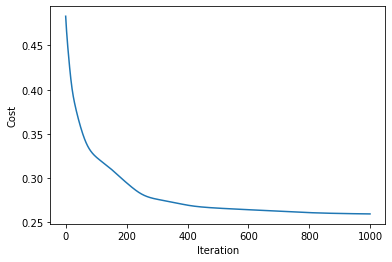

In [19]:
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost');

# Visualise trained classifier

In [20]:
linsp = jnp.linspace(-1, 1, 100)
Z = vmap(lambda a: vmap(lambda b: param_and_x_to_probability(param, jnp.array([a, b])))(linsp))(linsp)

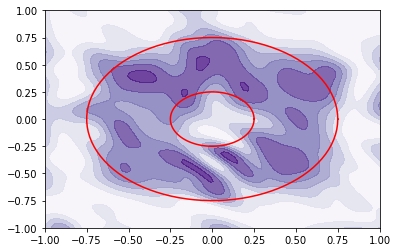

In [21]:
plt.contourf(linsp, linsp, Z, cmap='Purples', alpha=0.8)
circle_linsp = jnp.linspace(0, 2 * jnp.pi, 100)
plt.plot(inner_rad * jnp.cos(circle_linsp), inner_rad * jnp.sin(circle_linsp), c='red')
plt.plot(outer_rad * jnp.cos(circle_linsp), outer_rad * jnp.sin(circle_linsp), c='red');

Looks good, it has clearly grasped the donut shape. Sincerest apologies if you are now hungry! 🍩